1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.
Turn the data into PyTorch tensors.
Split the data into training and test sets using train_test_split with 80% training and 20% testing.

         X1        X2  label
0 -0.111667  0.520224      1
1  1.142650 -0.342577      1
2  0.795558 -0.011442      1
3  0.111827 -0.551932      1
4 -0.816466  0.543996      0
5  0.662510 -0.084356      1
6  0.274510 -0.189904      1
7 -0.115556  0.535912      1
8  1.572369 -0.335447      1
9  0.763990  0.962359      0


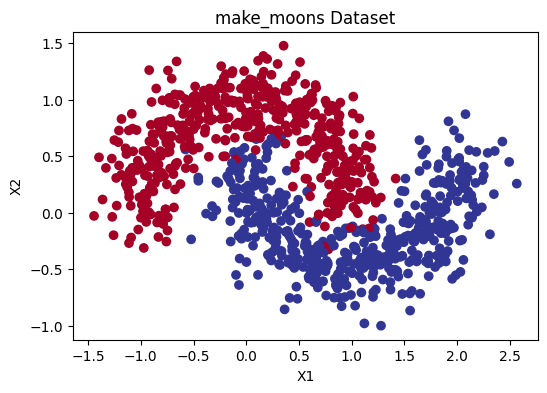

Training samples: 800, Testing samples: 200


In [1]:
# Import necessary libraries
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Setup random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Create a binary classification dataset with 1000 samples using make_moons
X_np, y_np = make_moons(n_samples=1000, noise=0.2, random_state=RANDOM_SEED)

# Turn the data into a DataFrame (optional, but useful for visualization)
df = pd.DataFrame({"X1": X_np[:, 0], "X2": X_np[:, 1], "label": y_np})
print(df.head(10))

# Visualize the data on a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(df["X1"], df["X2"], c=df["label"], cmap=plt.cm.RdYlBu)
plt.title("make_moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Convert NumPy arrays to PyTorch tensors (dtype float for features, float for labels as well)
X = torch.from_numpy(X_np).type(torch.float)
y = torch.from_numpy(y_np).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [2]:
# Setup device agnostic code (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define a model for the moon data using non-linear activations
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # First layer: input 2 features -> 8 neurons
        self.layer1 = nn.Linear(in_features=2, out_features=8)
        # Second layer: non-linearity will be applied after layer1, then another linear layer
        self.layer2 = nn.Linear(in_features=8, out_features=4)
        # Third layer: output layer: 4 -> 1 (binary classification)
        self.layer3 = nn.Linear(in_features=4, out_features=1)
        # We will use ReLU non-linearity after the first two layers

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)        # Apply non-linearity
        x = self.layer2(x)
        x = torch.relu(x)        # Apply non-linearity
        x = self.layer3(x)       # No activation here because we'll use BCEWithLogitsLoss
        return x

# Instantiate the model and move it to the chosen device
model_0 = MoonModelV0().to(device)
print(model_0)

Using device: cpu
MoonModelV0(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=4, bias=True)
  (layer3): Linear(in_features=4, out_features=1, bias=True)
)


3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [4]:
# Use BCEWithLogitsLoss for binary classification (it includes a sigmoid internally)
loss_fn = nn.BCEWithLogitsLoss()

# Use SGD optimizer with a learning rate of 0.1 (you can experiment with this)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
Train the model for long enough for it to reach over 96% accuracy.
The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [5]:
# Define a simple accuracy function for binary classification
def accuracy_fn(y_true, y_pred):
    # y_pred is expected to be probabilities (0-1); threshold at 0.5 to get labels
    y_pred_labels = torch.round(torch.sigmoid(y_pred))
    correct = (y_pred_labels.squeeze() == y_true).sum().item()
    acc = correct / len(y_true)
    return acc * 100

# Set number of epochs
epochs = 1000

# Move training data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
for epoch in range(epochs):
    # Set model to train mode
    model_0.train()
    # Forward pass: compute logits (raw outputs)
    y_logits = model_0(X_train)
    # Compute loss by comparing raw outputs with true labels (unsqueezed to match shape)
    loss = loss_fn(y_logits.squeeze(), y_train)
    # Compute accuracy
    acc = accuracy_fn(y_train, y_logits)

    # Backpropagation
    optimizer.zero_grad()  # Clear gradients from previous iteration
    loss.backward()        # Compute gradients
    optimizer.step()       # Update parameters

    # Every 100 epochs, evaluate on test data
    if epoch % 100 == 0:
        model_0.eval()
        with torch.inference_mode():
            test_logits = model_0(X_test)
            test_loss = loss_fn(test_logits.squeeze(), y_test)
            test_acc = accuracy_fn(y_test, test_logits)
        print(f"Epoch: {epoch:03d} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Final evaluation on test set
model_0.eval()
with torch.inference_mode():
    test_logits = model_0(X_test)
    test_loss = loss_fn(test_logits.squeeze(), y_test)
    test_acc = accuracy_fn(y_test, test_logits)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.2f}%")

# Let's see the model outputs on test data
print("Logits:")
print(test_logits[:10])
print("Pred Probs (after sigmoid):")
print(torch.sigmoid(test_logits[:10]))
print("Pred Labels (after thresholding at 0.5):")
print(torch.round(torch.sigmoid(test_logits[:10])))

Epoch: 000 | Loss: 0.6964 | Acc: 40.38% | Test Loss: 0.6918 | Test Acc: 42.50%
Epoch: 100 | Loss: 0.3542 | Acc: 85.12% | Test Loss: 0.3628 | Test Acc: 82.00%
Epoch: 200 | Loss: 0.2865 | Acc: 86.88% | Test Loss: 0.2849 | Test Acc: 86.00%
Epoch: 300 | Loss: 0.2702 | Acc: 88.25% | Test Loss: 0.2634 | Test Acc: 87.00%
Epoch: 400 | Loss: 0.2566 | Acc: 88.62% | Test Loss: 0.2476 | Test Acc: 88.00%
Epoch: 500 | Loss: 0.2381 | Acc: 90.00% | Test Loss: 0.2267 | Test Acc: 89.00%
Epoch: 600 | Loss: 0.2128 | Acc: 91.00% | Test Loss: 0.1991 | Test Acc: 90.50%
Epoch: 700 | Loss: 0.1827 | Acc: 92.62% | Test Loss: 0.1673 | Test Acc: 92.50%
Epoch: 800 | Loss: 0.1542 | Acc: 94.50% | Test Loss: 0.1368 | Test Acc: 95.00%
Epoch: 900 | Loss: 0.1320 | Acc: 95.62% | Test Loss: 0.1127 | Test Acc: 97.00%

Final Test Loss: 0.0961 | Final Test Acc: 98.00%
Logits:
tensor([[ 3.8233],
        [-3.1969],
        [ 4.4002],
        [-6.6985],
        [ 6.4855],
        [ 7.8122],
        [-0.8033],
        [-0.5774],


5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

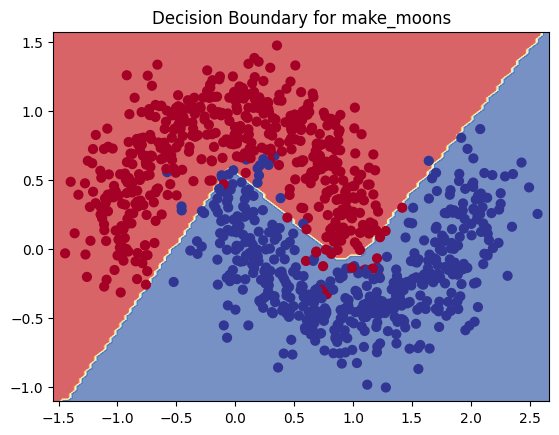

In [6]:
def plot_decision_boundary(model, X, y):
    # Move model and data to CPU for plotting
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Create a mesh grid over the feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Prepare the grid data for prediction
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Get model predictions for the grid
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # For binary classification, use sigmoid then threshold at 0.5
    y_pred = torch.round(torch.sigmoid(y_logits))
    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    # Plot the decision boundary and the original points
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary for make_moons")
    plt.show()

# Plot decision boundary using training data (you can also try X_test, y_test)
plot_decision_boundary(model_0, X, y)

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the ML cheatsheet website for the formula.

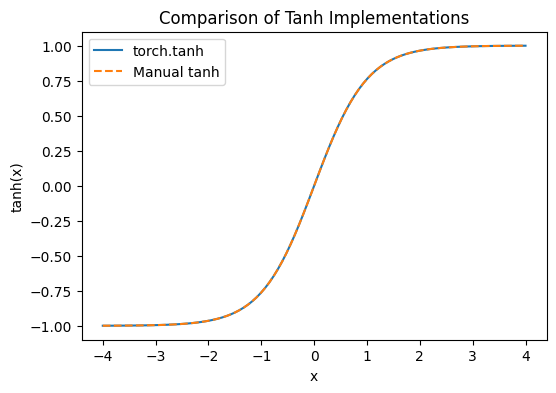

In [7]:
# Create a tensor of values from -4 to 4
x_values = torch.linspace(-4, 4, steps=100)
# Compute Tanh using torch.tanh
tanh_builtin = torch.tanh(x_values)

# Manually compute Tanh using its formula: (exp(x) - exp(-x)) / (exp(x) + exp(-x))
exp_x = torch.exp(x_values)
exp_neg_x = torch.exp(-x_values)
tanh_manual = (exp_x - exp_neg_x) / (exp_x + exp_neg_x)

# Plot both curves to see they are the same
plt.figure(figsize=(6, 4))
plt.plot(x_values.numpy(), tanh_builtin.numpy(), label="torch.tanh")
plt.plot(x_values.numpy(), tanh_manual.numpy(), '--', label="Manual tanh")
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.legend()
plt.title("Comparison of Tanh Implementations")
plt.show()

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

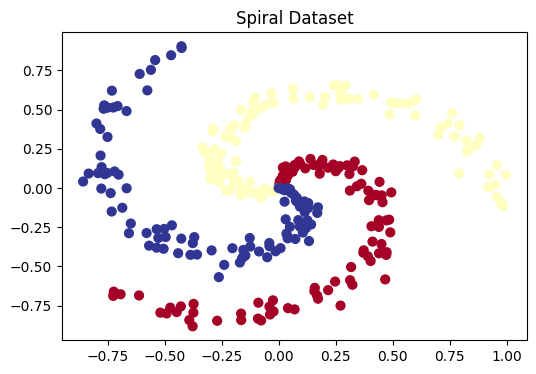

In [8]:
# Create a spiral dataset (from CS231n)
np.random.seed(RANDOM_SEED)
N = 100  # number of points per class
D = 2    # dimensionality
K = 3    # number of classes
X_spiral = np.zeros((N*K, D))
y_spiral = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)           # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N) * 0.2  # theta with noise
    X_spiral[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y_spiral[ix] = j

# Visualize the spiral dataset
plt.figure(figsize=(6, 4))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, s=40, cmap=plt.cm.RdYlBu)
plt.title("Spiral Dataset")
plt.show()

In [9]:
# Convert spiral data to PyTorch tensors
X_spiral_tensor = torch.from_numpy(X_spiral).type(torch.float)
y_spiral_tensor = torch.from_numpy(y_spiral).type(torch.LongTensor)

# Split into train and test sets (80% train, 20% test)
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(
    X_spiral_tensor, y_spiral_tensor, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Spiral Train samples: {len(X_spiral_train)}, Spiral Test samples: {len(X_spiral_test)}")

Spiral Train samples: 240, Spiral Test samples: 60


In [10]:
# Define a multi-class model for the spiral dataset
class SpiralModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=3)  # 3 classes
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)  # No softmax here; CrossEntropyLoss applies it internally
        return x

# Instantiate the multi-class model and move to device
spiral_model = SpiralModelV0().to(device)
print(spiral_model)

SpiralModelV0(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=3, bias=True)
)


In [12]:
# For multi-class classification, use CrossEntropyLoss
loss_fn_multi = nn.CrossEntropyLoss()

# Use Adam optimizer for multi-class model (can experiment with learning rate)
optimizer_multi = torch.optim.Adam(spiral_model.parameters(), lr=0.01)

# Define a simple accuracy function for multi-class classification
def accuracy_fn_multi(y_true, y_pred_logits):
    # y_pred_logits: raw outputs; use argmax along dim=1 to get predicted class
    y_pred = torch.argmax(y_pred_logits, dim=1)
    correct = (y_pred == y_true).sum().item()
    acc = correct / len(y_true)
    return acc * 100

In [13]:
# Move spiral training data to the device
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

# Set number of epochs for spiral training
epochs_multi = 1000

for epoch in range(epochs_multi):
    spiral_model.train()
    # Forward pass on training data
    y_logits_train = spiral_model(X_spiral_train)
    loss_train = loss_fn_multi(y_logits_train, y_spiral_train)
    acc_train = accuracy_fn_multi(y_spiral_train, y_logits_train)

    optimizer_multi.zero_grad()
    loss_train.backward()
    optimizer_multi.step()

    # Evaluate on test data every 100 epochs
    if epoch % 100 == 0:
        spiral_model.eval()
        with torch.inference_mode():
            y_logits_test = spiral_model(X_spiral_test)
            loss_test = loss_fn_multi(y_logits_test, y_spiral_test)
            acc_test = accuracy_fn_multi(y_spiral_test, y_logits_test)
        print(f"Epoch: {epoch:03d} | Train Loss: {loss_train:.4f} | Train Acc: {acc_train:.2f}% | Test Loss: {loss_test:.4f} | Test Acc: {acc_test:.2f}%")

# Final evaluation on spiral test set
spiral_model.eval()
with torch.inference_mode():
    y_logits_test = spiral_model(X_spiral_test)
    loss_test = loss_fn_multi(y_logits_test, y_spiral_test)
    acc_test = accuracy_fn_multi(y_spiral_test, y_logits_test)
print(f"\nFinal Spiral Test Loss: {loss_test:.4f} | Final Spiral Test Acc: {acc_test:.2f}%")

# Print sample outputs
print("Spiral model logits (first 10):")
print(y_logits_test[:10])

Epoch: 000 | Train Loss: 1.1109 | Train Acc: 26.25% | Test Loss: 1.0831 | Test Acc: 35.00%
Epoch: 100 | Train Loss: 0.4259 | Train Acc: 79.17% | Test Loss: 0.3641 | Test Acc: 80.00%
Epoch: 200 | Train Loss: 0.2290 | Train Acc: 92.50% | Test Loss: 0.2133 | Test Acc: 91.67%
Epoch: 300 | Train Loss: 0.0401 | Train Acc: 99.17% | Test Loss: 0.0141 | Test Acc: 100.00%
Epoch: 400 | Train Loss: 0.0285 | Train Acc: 99.17% | Test Loss: 0.0053 | Test Acc: 100.00%
Epoch: 500 | Train Loss: 0.0238 | Train Acc: 99.17% | Test Loss: 0.0022 | Test Acc: 100.00%
Epoch: 600 | Train Loss: 0.0211 | Train Acc: 99.17% | Test Loss: 0.0016 | Test Acc: 100.00%
Epoch: 700 | Train Loss: 0.0193 | Train Acc: 99.17% | Test Loss: 0.0014 | Test Acc: 100.00%
Epoch: 800 | Train Loss: 0.0181 | Train Acc: 99.17% | Test Loss: 0.0015 | Test Acc: 100.00%
Epoch: 900 | Train Loss: 0.0172 | Train Acc: 99.17% | Test Loss: 0.0018 | Test Acc: 100.00%

Final Spiral Test Loss: 0.0022 | Final Spiral Test Acc: 100.00%
Spiral model logit

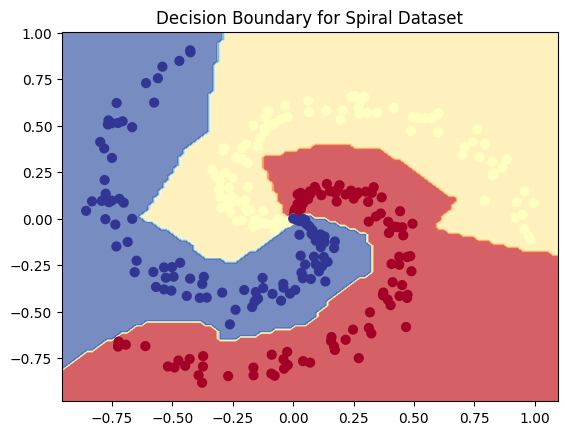

In [14]:
def plot_decision_boundary_multi(model, X, y):
    # Move model and data to CPU for plotting
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Create a mesh grid over the feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Prepare grid features
    X_grid = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_grid)

    # For multi-class, use softmax then argmax
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    # Plot decision boundaries and data points
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary for Spiral Dataset")
    plt.show()

# Plot decision boundary for the spiral model using all spiral data
plot_decision_boundary_multi(spiral_model, X_spiral_tensor, y_spiral_tensor)